In [ ]:
from IPython.display import Image, HTML
%matplotlib inline

# Blind Deconvolution
**The [complete implementation](https://github.com/scottsievert/ece533_finalproj) can be found on GitHub**<br>
**Authors**: [Scott Sievert](http://scottsievert.com), Gunnet Singh Mehta, Smita Bagewadi

## Deconvolution
[Deconvolution] is a classic problem in signal processing. Given observations $y$ from an LTI system or $y = h \otimes x + n$ with *precise* knowledge of $h$, the true signal $x$ would like to be estimated. This could be estimating a signal after a transmission through a lossy channel. This is common in many fields an everyday example is estimating an image after some distortion applied (signal known to be averaged by so many elements, etc).

Many methods exist to solve this problem with *precise* knowledge of $h$. Any of the methods used in Lab 4 would apply, but there are more methods. We could use any of the following to get a good estimate of $x$ from knowledge of $y$ and $h$:

* [Wiener filtering]
* [TV denoising] (see [Beck et. al](#References))
* $\ell_2$ regularization (aka [Tikhonov regularization]) to ensure that our estimate doesn't grow large as our noise increases
* $\ell_1$ regularization, using sparsity in the wavelet basis
* [Richardson-Lucy deconvolution], a method using Baye's Theorem

The methods can be perform remarkably well suited when $h$ is known with high accuracy, even in the presence of noise. For example, when we use $\ell_2$ regularization and form an estimate $\widehat{x}$ with
$$\widehat{x} = \arg \min_x \left|\left|y - h\otimes x\right|\right|_2^2 + \lambda \cdot||x||_2^2$$
when $h$ is a averaging operation. The below widget shows the implementation of this approximation. The regularization parameter $||x||^2_2$ prevents estimate signal $\widehat{x}$ from becoming unreasonably large by limiting the total "energy" in the signal. With naîve approach, inverse filtering, the values will only become unreasonably large.

(note: you can play with this! You can change the observed noise and the regularization parameter. This is much more noise tolerant than the inverse filter, which gives *exact* reconstruction when no noise added but the second noise is added the values increase unrealistically)

[Richardson-Lucy deconvolution]:https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution
[Tikhonov regularization]:https://en.wikipedia.org/wiki/Tikhonov_regularization
[TV denoising]:https://en.wikipedia.org/wiki/Total_variation_denoising
[Wiener filtering]:https://en.wikipedia.org/wiki/Wiener_filter
[Deconvolution]:https://en.wikipedia.org/wiki/Deconvolution

In [2]:
HTML('figures/widgets/2015-inverse-1-blur_l2_reg.html')

## Blind Deconvolution
[Blind deconvolution] is a much more real-world example of deconvolution. We might not *exactly* know the filter, but might have an estimate. For example, we might know it's a Gaussian filter function but don't exactly know how wide it is -- we might have an estimate for $\sigma$ but not know it exactly. We can not perform the inverse filter for many different values because $\sigma$ is continuous and testing every $\sigma$ would take an uncountably infinite amount of time.

[Blind deconvolution]:https://en.wikipedia.org/wiki/Blind_deconvolution

Mathematically, we are given possibly noisy observations $y$ and asked to estimate $x$ without knowledge of $h$.
$$y = h \otimes x + n$$
This is an extremely ill-posed problem. We only know the structure for $y$ but we don't know $x$, $h$ or $n$. In general, this problem is extremely ill-posed -- only $y$ is known and the other three variables $(x, h, n)$ can take any other value.

This problem becomes better posed when we have more constraints. For example, it might be known that both $x$ and $h$ cannot have non-zero coefficients (because a negative number of photons can't hit a sensor and it can be known that $h$ is a low-pass filter).

It becomes tractable once we have an *estimate* for $h$. In practice, this often means that we know $h$ is a Gaussian blur but are unsure of the blur variance.

## Applications
The [Hubble telescope flawed mirror] is by far the best example of blind deconvolution. When it launched in 1992, NASA discovered that the mirror had been flawed (NASA couldn't test it on Earth due to atmospheric effects). Later analysis showed that it was only warped by a small amount (roughly 10 nanometers). This error happened during manufacturing, even though it was the most precisely designed mirror to date.

[Hubble telescope flawed mirror]:https://en.wikipedia.org/wiki/Hubble_Space_Telescope#Flawed_mirror

This means that when the snapped the first picture, they got the image on the left when they were expecting the image on the right:

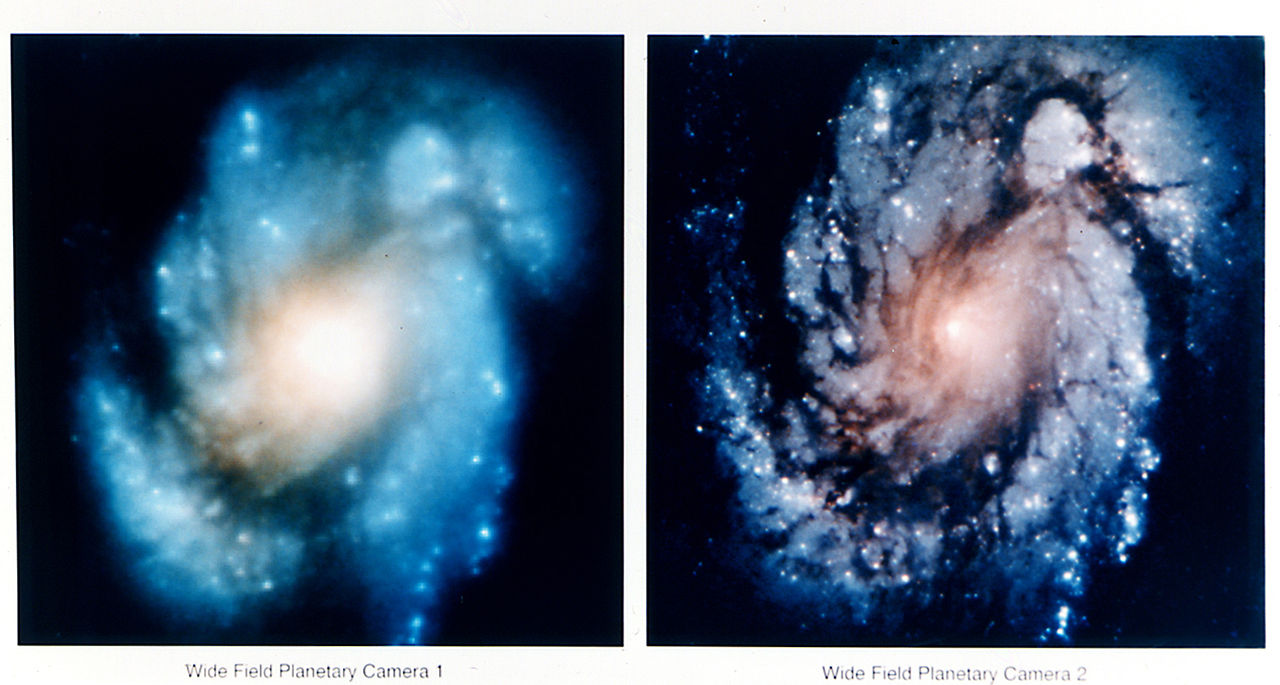

In [3]:
Image('figures/hubble.jpg')

This sparked off research in blind deconvolution. The camera that snapped this photo existed in space meaning it would have been expensive to fix (although they eventually did fix it with more mirrors as described in section [Design of a solution]).

[Design of a solution]:https://en.wikipedia.org/wiki/Hubble_Space_Telescope#Design_of_a_solution

## Theoretical approach
We observe $y = h \otimes x + n$ and it can be assumed we have an estimate for $h$ as $\widehat{h}$. We observe $y$ and would like to estimate $x$ in the presence of noise.

To solve this problem, we will use the alternating minimization algorithm, which is related to [biconvexity]. We will fix $\widehat{h}$ and find the optimal estimate of our original signal, $\widehat{x}$. We will then fix $\widehat{x}$ and optimize for $\widehat{h}$. Pictorially,

[biconvexity]:https://en.wikipedia.org/wiki/Biconvex_optimization

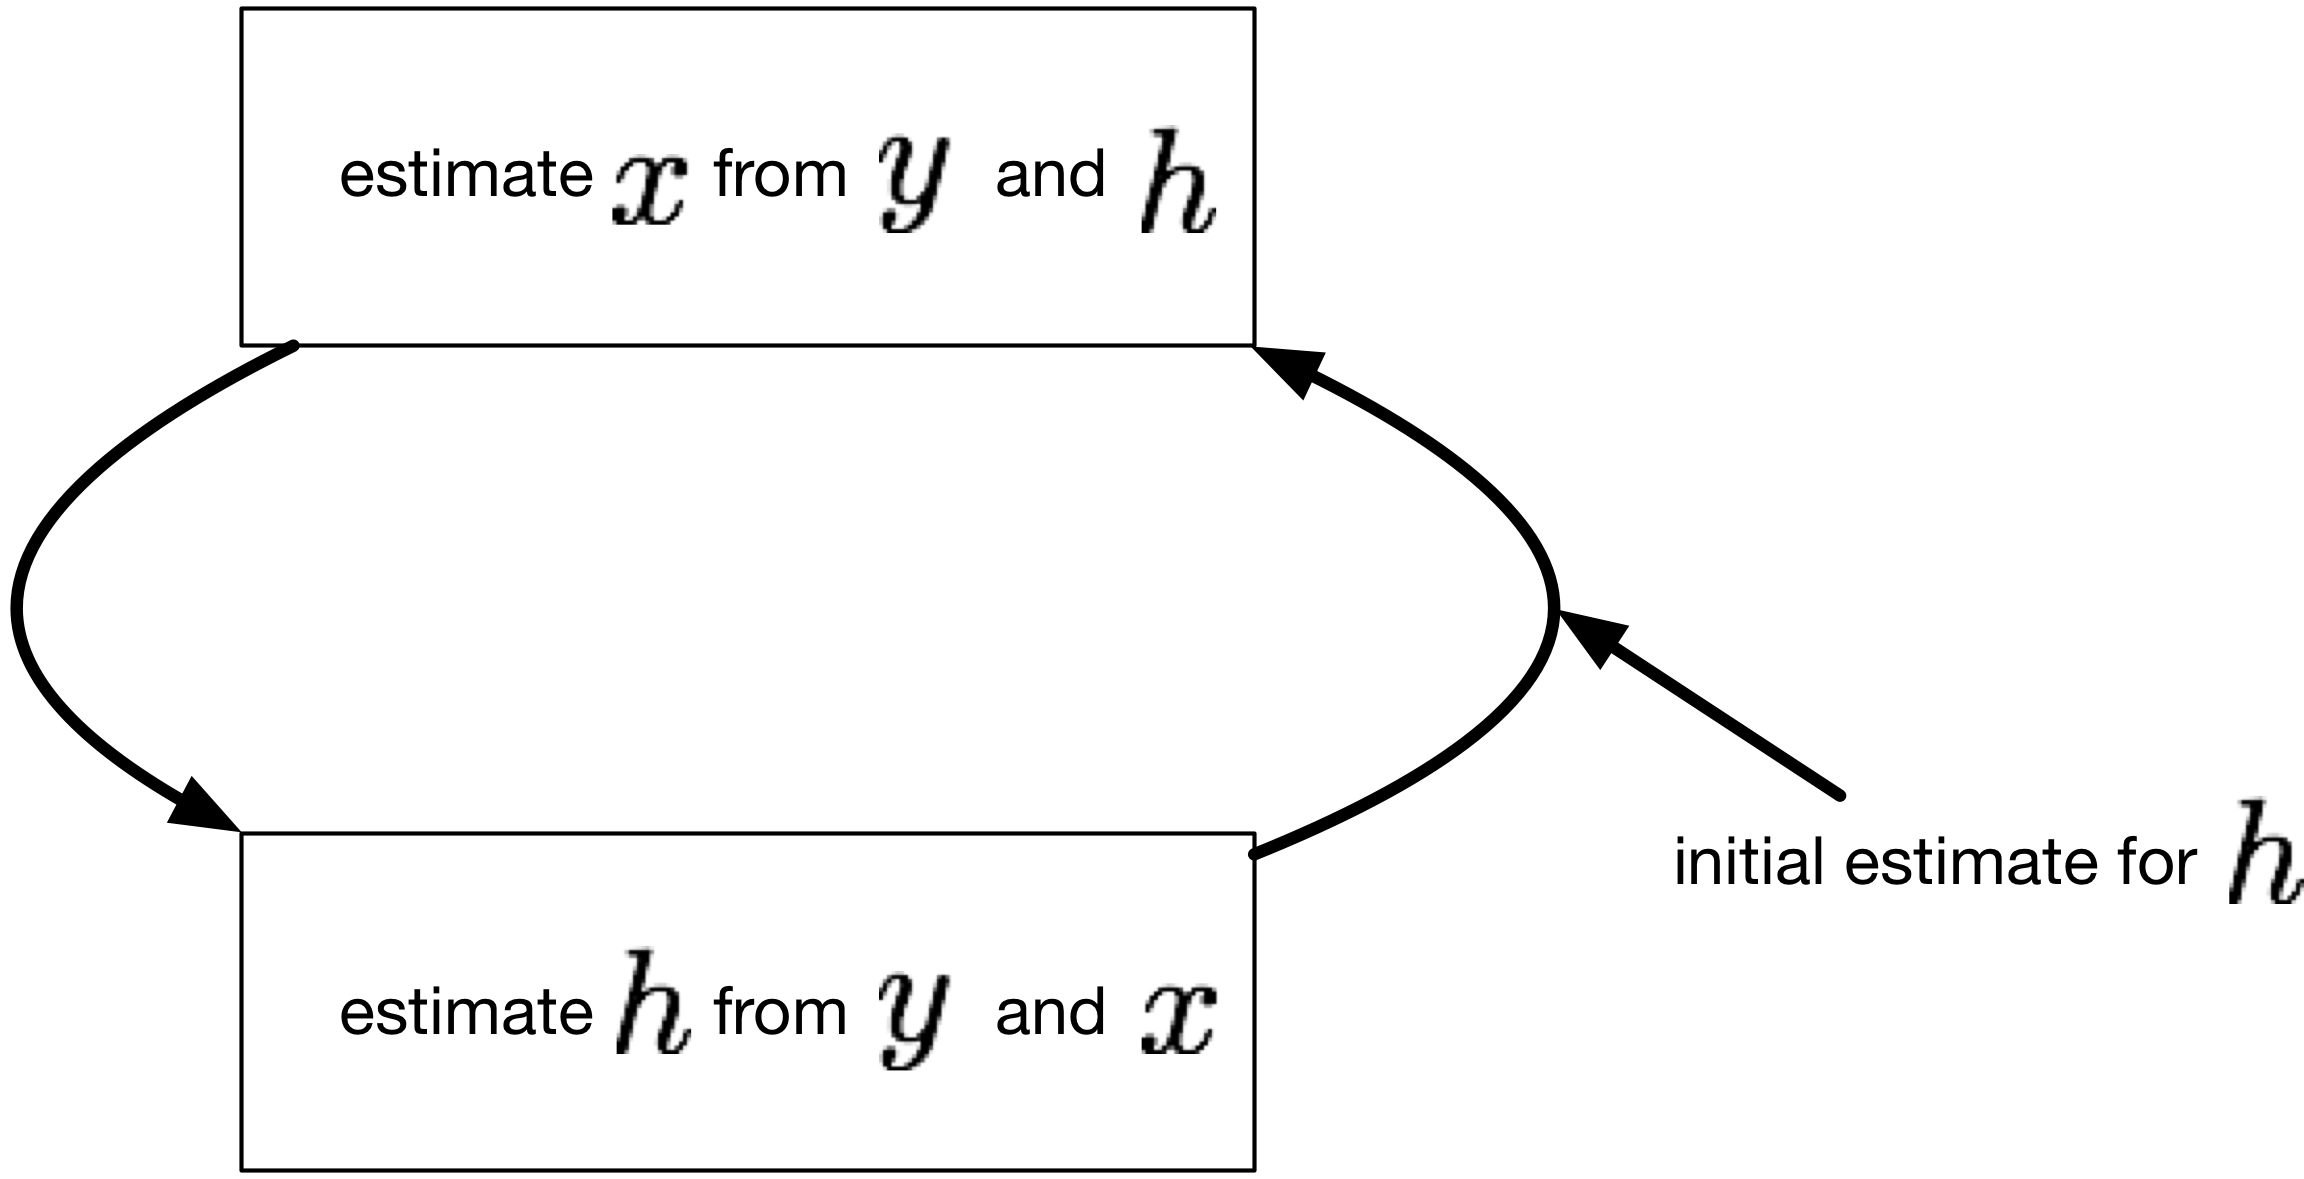

In [4]:
Image('figures/loop.png', width=400)

Formally, we can represent this by saying that our current estimate at iteration $k$ is

$$\begin{align}
x_{k} &= f\left(y, h_{k-1}\right)\\
h_{k} &= f\left(y, x_{k}\right)
\end{align}$$

For more detail on this alternating minimization method, see [Gorski et. al.]. This method says “fix one variable and optimize for the other variable from you observations” and go back and forth. This method is widespread; we found it in every blind deconvolution reference we found, and alternating minimization algorithms are even found in other areas such as [biconvex optimization] (through the [proximal gradient method]) and unsupervised learning (at least for [dictionary learning]).

[dictionary learning]:https://en.wikipedia.org/wiki/Machine_learning#Sparse_dictionary_learning

These steps can be summarized in two steps:

1. Take a step in the direction that optimizes $X_{k+1}$ with knowledge of $Y$ and $H_k$.
2. With this new estimate $X_{k+1}$ and knowledge of $Y$, optimize for $H_{k+1}$.

We can treat these methods like black boxes and just look at the input and output. We are finding a better estimate; how we produce it doesn’t affect practical performance (although it may be harder to analyze from a theoretical standpoint).

[proximal gradient method]:https://en.wikipedia.org/wiki/Proximal_gradient_methods_for_learning
[biconvex optimization]:https://en.wikipedia.org/wiki/Biconvex_optimization
[Gorski et. al.]:http://www2.math.uni-wuppertal.de/~klamroth/publications/gopfkl07.pdf

Below, we will describe Richardson-Lucy blind deconvolution. However, this is not the only approach to this problem and other methods exist. Some of these methods are

* Total variation blind deconvolution ([Chan et al][ref])
* Blind deconvolution using a normalized sparsity measure ([Krishan et. al][ref])

[ref]:#References



### Richardson-Lucy deconvolution
The [Richardson-Lucy deconvolution] algorithm is the basis for the blind deconvolution algorithm. The algorithm was developed in the early 1970s by Richardson and Lucy and has been re-derived by Shepp and Vardi as an algorithm to solve positron imaging problems. This algorithm has become particularly famous in astronomy and medical imaging where there is high level of noise and the imaging equipment characteristics often changes due to factors beyond control (e.g.,  the impulse filter function $h$ can vary over time).

[Richardson-Lucy deconvolution]:https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution

The well known [Baye's theorem] is used here and is well-known in the probability literature. It provides a formula to compute the probability of a model existing given the fact that the given observations were collected or

[Baye's theorem]:https://en.wikipedia.org/wiki/Bayes%27_theorem

$$P(x|y) = \frac{P(y|x) \cdot P(x)}{\int P(y|x) P(x) dx}$$

This provides a formula to form the probability of a certain model $x$ given the observations $y$ which is typically hard to calculate. It does this using the probability of collecting certain measurements given a certain model (which is typically easier to calculate).

ask the question "what's the probability of my model $x$ given that I collected these observations" using the question "given my model $x$, what's the probability I collected these measurements?"

* In this equation, the bottom integral is $P(y)$ (a standard exercise in [conditional probability]).
* $P(y|x)$ - conditional probability of occurrence of $y$ given $X = x$
* $P(x)$ - probability that $X = x$ and standard [probability density].
* $P(x|y)$ - conditional probability of the $x$ being a particular value given that $Y = y$

[conditional probability]:https://en.wikipedia.org/wiki/Conditional_probability
[probability density]:https://en.wikipedia.org/wiki/Probability_density_function

In the imaging case, this would be the probability of having a particular blurring kernel $h$ after making our observations.  As found in [Fish et. al.](#References) this Bayesian rule can be converted into image domain variables to

$$x_{i+1}(l) = \left[\left( \frac{y(l)}{x_i(l) \otimes h(l)}\right) \otimes h(-l) \right] x_i(l)$$

where $l$ is some location and $h(-l)$ is the mirror of $h(l)$ (the above equation generalizes easily to multiple dimensions). Note that in this Richardson Lucy deconvolution we assume that we know the kernel exactly. 


### Richardson Lucy Algorithm in blind deconvolution
The Richardson-Lucy Algorithm is agnostic to the convolution operator: it makes no assumptions about whether the $x$ or $h$ is the convolution operator. Given the alternating minimization approach described in [Theoretical approach](#Theoretical-approach), that means the blind deconvolution approach is simple:

1. Use the Richardson-Lucy algorithm to estimate $x$ from $y$ and the most recent estimate of $h$.
2. Use the Richardson-Lucy algorithm to estimate $h$ from $y$ and the most recent estimate of $x$
3. Loop back to (1) until convergence criterion satisfied.

In mathematics, that takes the following form:

$$\begin{align}
x_{i+1}^k(l) &= \left[\left( \frac{y(l)}{x^k_i(l) \otimes h^{k-1}(l)}\right) \otimes h^k(-l) \right] x^k_i(l)\\
h_{i+1}^k(l) &= \left[\left( \frac{y(l)}{h^k_i(l) \otimes x^{k}(l)}\right) \otimes x^{k-1}(-l) \right] h^k_i(l)\\
\end{align}$$

The above equations are the Richardson Lucy implementation for the blind deconvolution problem. In the equation for $h^{k}_{i+1}$ we find a better estimate of the filter by using the observed output $y$, the estimate for the input image $x^k$ and the *current* estimate for the filter or $h_k$. The estimation for the filter is refined iteratively.

A similar process is repeated to get a better estimate for the image $x_{i+1}^k$ using the refined filter value. It uses Bayesian theory to calculate what the filter/image *should* be given the observations and the current estimate for the image/filter.

It was observed in implementation that this algorithm did not perform well when the refinement for image estimate $x$ and $h$ immediately after one another (i.e., only 1 refinement done to estimate $x$ and $h$). The algorithm performed better when both filter and image were refined multiple times (7 times) before moving on to refine image/kernel. This makes sense after thinking about the Richardson-Lucy process as a black box that produces a good estimate for one variable given the two other variables.

The method of reconstruction of image from an estimate of kernel could have been replaced by any one of the methods (Weiner, Tikhinov regularisation, Richardson Lucy deconvolution).

## Implementation
Given this setup, the implementation is relatively straightforward. Given possibly noisy observations $y$ and an *estimate* for the convolution kernel $h_0$, we can step into a for-loop to predict each variable. [The complete implementation] can be found on GitHub, but we also describe it below.

In the implementation below, we say that our estimate for $h$ is a Gaussian blurring function, and the true $h$ is a Gaussian blurring function; this is a reasonable estimate. However, our estimate is incorrect and the width of the Gaussian is off by a factor of 1.5.

[The complete implementation]:https://github.com/scottsievert/ece533_finalproj

```python
clc; clear all; close all;
f = functions_();

#% can see results with blur_sigma=6, iterations=8, lucy_iterations=7, sigma=1e-4
blur_sigma = 6;
[x, X, h, H, y, Y, n] = f.input_and_observations(blur_sigma);
blur_sigma_hat = 1.5*blur_sigma;
[~, ~, h_hat, ~, ~, ~, ~] = f.input_and_observations(blur_sigma_hat);

#% How many iterations are required to get a good approximation for the variable
#% we're optimizing before?
lucy_iterations = 7;

#% How many times do we switch back and forth between optimizing for each
#% variable?
iterations = 20;
for k=1:iterations,
    #% Optimize for x_hat. These values can be treated as a black box; we can
    #% swap any of the out (makes sense by looking at the input/outputs)
    x_hat = deconvlucy(y, h_hat, lucy_iterations);
    #%x_hat = deconvwnr(y, h_hat);
    #%x_hat = deconvreg(y, h_hat);
    
    #% Estimate H. Richardson-Lucy doesn't make any assumptions about the form of
    #% the equation and X and H are interchangable. It goes of the Fourier
    #% tranfrom representation.
    h_hat = deconvlucy(y, x_hat, lucy_iterations);
end

#% display the results (shown below but code can be found on GitHub)
```

The complete implementation of this script can be found on GitHub at [`implementation/blind_deconvolution_implementation.m`](https://github.com/scottsievert/ece533_finalproj/blob/master/implementation/blind_deconvolution_implementation.m).

In this implementation, we use Matlab’s `deconvlucy`. We ran into sizing issues which was combined with the parameter initialization issue (blind deconvolution is very sensitive to initial parameters). To ensure a correct output, we decided to go with [the Matlab implementation of Richardson-Lucy deconvolution][mrl], `deconvlucy`, which performs further checks. This script performs more checks/etc than other Richardson-Lucy implementations such as [scikit-image’s `richardson_lucy`] (our use of this function resulted in [scikit-image's pull request #1792]).

[scikit-image's pull request #1792]:https://github.com/scikit-image/scikit-image/pull/1792#event-490623976
[scikit-image’s `richardson_lucy`]:https://github.com/scikit-image/scikit-image/blob/master/skimage/restoration/deconvolution.py#L333
[The complete implementation]:https://github.com/scottsievert/ece533_finalproj
[mrl]:http://read.pudn.com/downloads112/sourcecode/graph/texture_mapping/464953/images/deconvlucy.m__.htm

## Results
Blind deconvolution is very sensitive to initial estimates and parameters because this is an ill-posed problem. To simulate a real-world process, we knew the form of the transfer function (a Gaussian) but not the variance/width. This would simulate a situation where we know our image is blurred by our camera/telescope but are uncertain exactly how it was blurred. To simulate this, our initial estimate is a Gaussian with a standard deviation of 1.5 times the true standard deviation. Using this initial estimate, we have run the deconvolution process and have plotted the results.

Then running the deconvolution process as mentioned in [*Implementation*](#implementation), we obtain the following results.


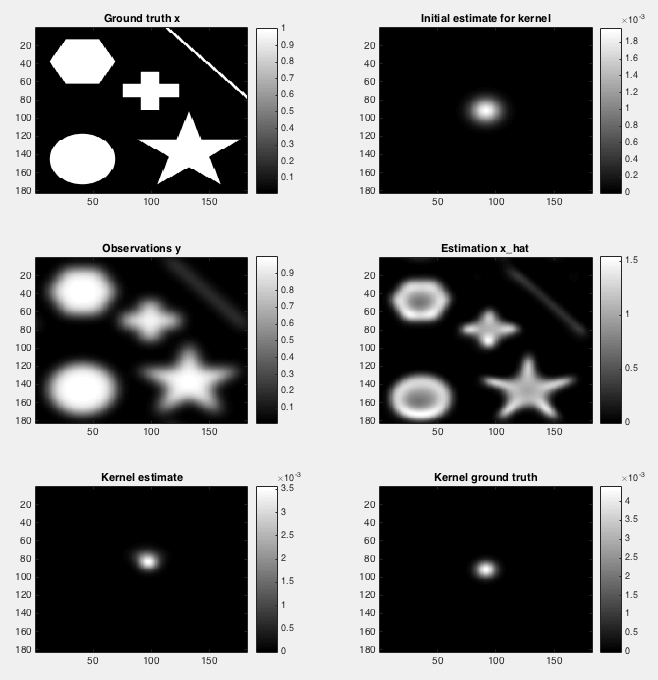

In [5]:
Image(filename='figures/lucy_lucy.png')

In this figure, the top row shows the ground truth image and the initial estimate for the convolution kernel. The second row shows our observations of the image and our estimate after the entire blind deconvolution process. We have also shown the true kernel and estimated kernel in the last row.

When thinking of the blind deconvolution process in terms of black boxes, we can replace the Richardson-Lucy deconvolution to estimate $x$ with knowledge of $y$ and $h_k$ with any similar deconvolution process. This could be inverse filtering, wavelet sparsity regularization, TV denoising, Wiener filtering or any other deconvolution algorithm.

After replacing this “estimate $x$ from $y$ and $h_k$” Richardson-Lucy block with an equivalent Wiener filter block, we get the following image:

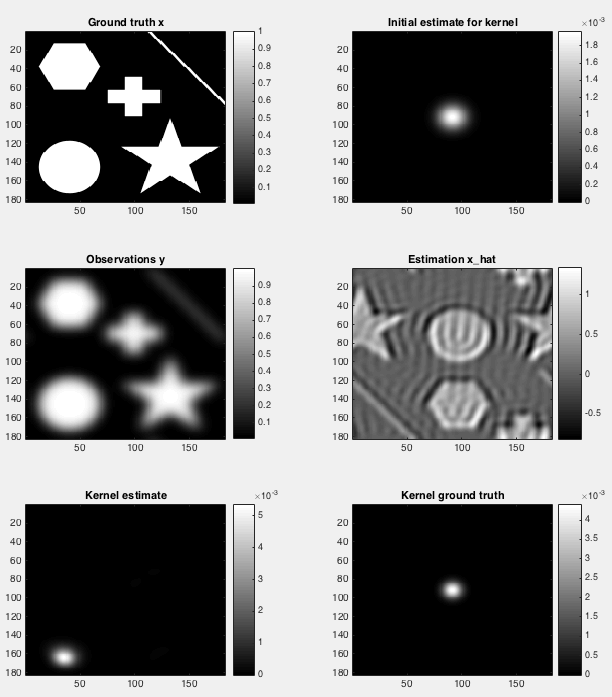

In [6]:
Image(filename='figures/lucy_weiner.png')

(this image follows the same format as the figure above). Further results can be found in [`figures/`](https://github.com/scottsievert/ece533_finalproj/tree/master/figures).

This gives sharper results, but is shifted. We might have prior knowledge that this blurring function’s center was at the origin (i.e., the Hubble telescope mirror had only been warped but not jolted out of place). This would allow us to move this convolution filter to the center of the image then perform the deconvolution using any of the deconvolution method mentioned.

## Conclusion
We have introduced the process of blind deconvolution. The framework we have introduced is one that includes alternating minimization and optimizes for each variable separately in a loop. We have shown that these methods can be treated as black boxes, only thinking about the inputs and outputs.

## References

[1]:http://www2.math.uni-wuppertal.de/~klamroth/publications/gopfkl07.pdf
[1_doi]:https://dx.doi.org/10.1007%2Fs00186-007-0161-1
[2]:http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=5173518
[3]:http://www.osapublishing.org/josaa/fulltext.cfm?uri=josaa-12-1-58&id=33094
[4]:http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=661187&tag=1
[5]:http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=5995521

1. Gorski, Jochen; Pfeuffer, Frank; Klamroth, Kathrin (22 June 2007). ["Biconvex sets and optimization with biconvex functions: a survey and extensions"][1] (PDF). Mathematical Methods of Operations Research 66 (3): 373–407. [doi:10.1007/s00186-007-0161-1][1_doi]
2. Beck, Amir, and Marc Teboulle. "[Fast gradient-based algorithms for constrained total variation image denoising and deblurring problems.][2]" Image Processing, IEEE Transactions on 18.11 (2009): 2419-2434.
3. Fish, D. A., et al. "[Blind deconvolution by means of the Richardson–Lucy algorithm.][3]" JOSA A 12.1 (1995): 58-65.
4. Chan, Tony F., and Chiu-Kwong Wong. "[Total variation blind deconvolution.][4]" Image Processing, IEEE Transactions on 7.3 (1998): 370-375.
5. Krishnan, Dilip, Terence Tay, and Rob Fergus. "[Blind deconvolution using a normalized sparsity measure.][5]" Computer Vision and Pattern Recognition (CVPR), 2011 IEEE Conference on. IEEE, 2011.